In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
from skimage import io, transform
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras import Model

In [2]:
#Importing the images
Image_path = 'D:\MTP_P1\W10\Trial_2D_TopDeep\Excel_data\img'
coll = skimage.io.ImageCollection(Image_path + '/*.png') 

#coll has the images as they are in the directory i.e is sorted order, also name of files can be viewed as coll.files[0] , shape as col[0].shape
width = 120
length = 120
# Now we will resize the image into 50*100 (width*length) , for that first we make a list as assignment is not allowed in ImageCollection, then push list itemps to a numpy array of required size
img_list = []
for i in range(len(coll)):
    img = transform.resize(coll[i], output_shape=(width,length))
    img_list.append(img)

img_arr = np.empty((120,width,length,3)) #initializes an empty numpy array which will contain 120 entries, each entry will be a 3 stacked matrices.
for i in range(120):
    img_arr[i] = np.asarray(img_list[i])


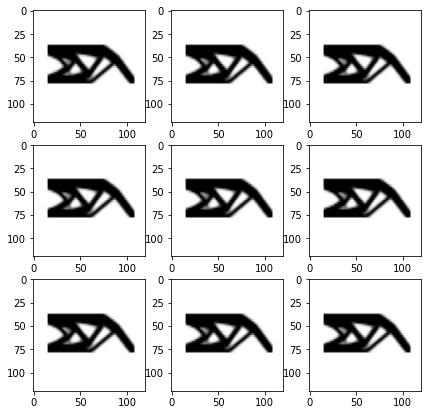

In [3]:
#visualizing the images
fig = plt.figure(figsize=(7, 7))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = img_arr[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [4]:
#now corresponding to each image we need an input tensor of size 50*100*3, matrices will contain volumefrac, fy , fx
top_set = np.empty((120,width,length,3))
#now we import our excel sheet which will provide the values with which we will populate our matrices
set_data = pd.read_excel("Top_setting.xlsx").values # .values will remove the headers i.e name of the columns

#updating the top_set to create our input with shape 120*50*100*3

for i in range(top_set.shape[0]):
    for j in range(top_set.shape[1]):
        for k in range(top_set.shape[2]):
            for l in range(top_set.shape[3]):
                top_set[i][j][k][l] = set_data[i][l]

# Now we have our input and outputs:
# input = top_set : shape - (120, 100, 100, 3)
# output = img_arr : shape - (120, 100, 100, 3)

In [5]:
#Now building The ANN_AutoEncoder Model

In [6]:
X_train, X_test, y_train, y_test = train_test_split( top_set, img_arr, test_size=0.2, random_state=0)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [7]:

#Initializing ANN
inputs = keras.Input(shape=(width,length,3),)

x = layers.Conv2D(32, 3, activation='relu',strides = 2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu',strides = 2, padding ='same')(x)
# x = layers.Conv2D(90, 3, activation='relu',strides = 1, padding ='same')(x)


conv_shape = keras.backend.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(100, activation ='relu')(x)


x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(x)
x = layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)

# x = layers.Conv2DTranspose(90, 3, activation='relu',strides = 1, padding ='same')(x)
x = layers.Conv2DTranspose(64, 3, activation = 'relu' , strides = 2, padding = 'same')(x)
x = layers.Conv2DTranspose(32, 3, activation = 'relu' , strides = 2, padding = 'same')(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation = 'sigmoid', padding = 'same')(x)

EncDeco = keras.Model(inputs, decoder_outputs, name='EncDeco')
EncDeco.summary()

Model: "EncDeco"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 100)               5760100   
                                                                 
 dense_1 (Dense)             (None, 57600)             5817600   
                                                                 
 reshape (Reshape)           (None, 30, 30, 64)        0   

In [8]:
# EncDeco.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# opt = keras.optimizers.SGD(learning_rate=lr_schedule)
# model.compile(loss='binary_crossentropy', optimizer=opt)
opt = keras.optimizers.Adam(learning_rate=0.001)
EncDeco.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
history = EncDeco.fit(X_train, y_train, batch_size = 15, epochs = 30, validation_data=(X_test, y_test))


Epoch 1/30
7/7 [==============================] - 2s 219ms/step - loss: 0.6886 - accuracy: 0.3329 - val_loss: 0.6789 - val_accuracy: 0.3953
Epoch 2/30
7/7 [==============================] - 1s 173ms/step - loss: 0.6543 - accuracy: 0.4013 - val_loss: 0.4600 - val_accuracy: 0.4071
Epoch 3/30
7/7 [==============================] - 1s 181ms/step - loss: 0.2771 - accuracy: 0.4216 - val_loss: 0.1902 - val_accuracy: 0.4047
Epoch 4/30
7/7 [==============================] - 1s 178ms/step - loss: 0.1749 - accuracy: 0.3720 - val_loss: 0.1683 - val_accuracy: 0.3142
Epoch 5/30
7/7 [==============================] - 1s 171ms/step - loss: 0.1613 - accuracy: 0.2828 - val_loss: 0.1516 - val_accuracy: 0.2296
Epoch 6/30
7/7 [==============================] - 1s 173ms/step - loss: 0.1432 - accuracy: 0.2356 - val_loss: 0.1357 - val_accuracy: 0.3129
Epoch 7/30
7/7 [==============================] - 1s 178ms/step - loss: 0.1333 - accuracy: 0.3675 - val_loss: 0.1325 - val_accuracy: 0.4041
Epoch 8/30
7/7 [====

1/1 [==============================] - 0s 104ms/step


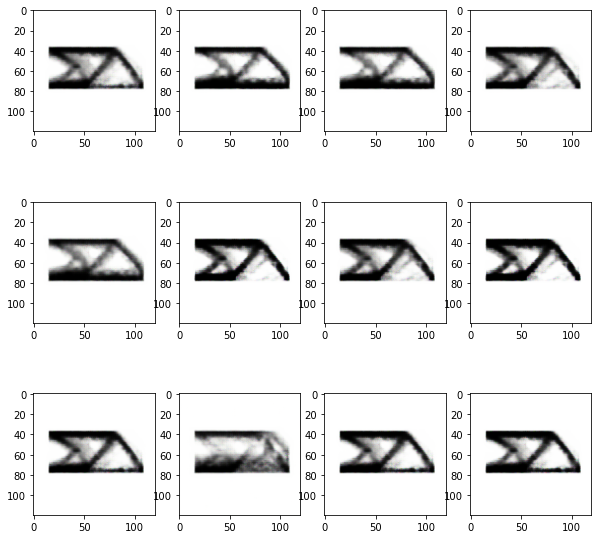

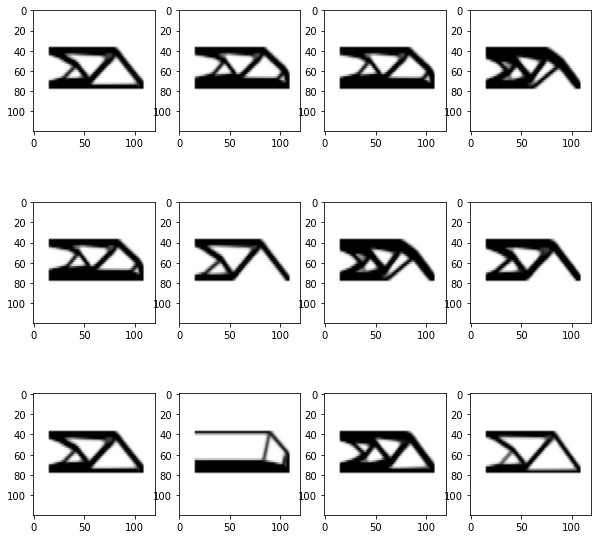

In [10]:
fig2 = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img =EncDeco.predict(X_test)
    fig2.add_subplot(rows, columns, i)
    plt.imshow(img[i-1])
plt.show()


fig1 = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = y_test[i-1]
    fig1.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()





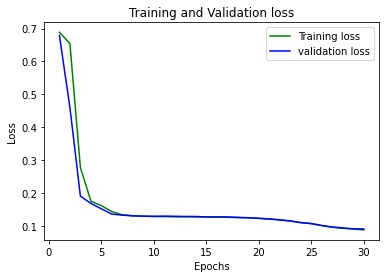

In [13]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

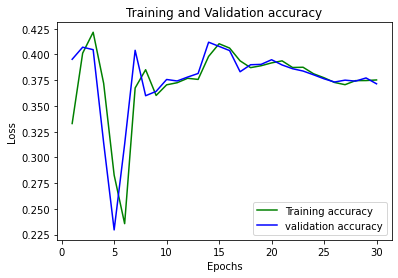

In [14]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
type(history.history)

dict

In [33]:
import xlsxwriter
 
workbook = xlsxwriter.Workbook('OutPut.xlsx')
worksheet = workbook.add_worksheet()
 
# Start from the first cell.
# Rows and columns are zero indexed.
row = 0
column = 0
 
content = history.history.get('val_loss')
 
# iterating through content list
for item in content :
 
    # write operation perform
    worksheet.write(row, column, item)
 
    # incrementing the value of row by one
    # with each iterations.
    row += 1
     
workbook.close()